
# Búsqueda Aproximada de Vecinos Más Cercanos (ANN) con LanceDB

 **IVF_PQ** 
(Indexado basado en archivos invertidos y cuantización por producto) 
sirve para realizar búsquedas rápidas en grandes conjuntos de vectores. 




In [4]:

# Cargar librerías necesarias
import time
import lancedb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:

# Configurar LanceDB
uri = "data/ANN"  # Directorio donde se guardará la base de datos
db = lancedb.connect(uri)

# Crear 10,000 vectores de muestra aleatorios
np.random.seed(42)  # Para reproducibilidad
data = [
    {"vector": row, "item": f"item {i}"}
    for i, row in enumerate(np.random.random((19_999_0, 1536)).astype("float32"))
]

# Crear tabla en la base de datos
tbl = db.create_table("mis_vectores", data=data)
print(f"Tabla 'mis_vectores' creada con {len(data)} vectores.")
# Mostrar las primeras 5 filas de la tabla




Tabla 'mis_vectores' creada con 199990 vectores.


### Parámetros de Configuración

- **`distance_type`**  
  Define la métrica de distancia(define qué tan "parecidos" son los datos) a utilizar. Por defecto, se emplea la distancia **Euclidiana** ("L2"). También se admiten las siguientes opciones:  
  - **`cosine`** 
    - Mide la similitud del ángulo entre dos vectores. Es útil cuando te interesa la orientación más que la magnitud (por ejemplo, para documentos)
  
  - **`dot`**  
    - Se basa en el producto escalar entre dos vectores, lo que resalta su magnitud y dirección
---

- **`num_partitions`**  
    - Especifica el número de particiones en el índice. El valor predeterminado es la raíz cuadrada del número de filas.
    - Sirve para mejorar el rendimiento en búsquedas. En lugar de comparar un vector contra toda la base de datos, solo se compara con los vectores dentro de una partición.


---

- **`num_sub_vectors`**  
  Indica el número de subvectores (**M**) que se generarán durante la **Cuantización de Producto** (*Product Quantization*, PQ). Para un vector de dimensión **D**, se dividirá en **M** subvectores de dimensión **D/M**, cada uno de los cuales será reemplazado por un único código PQ.  
  - **Valor predeterminado:** La dimensión del vector dividida por 16.
  - **Consideracion para eligir M**
    - Si eliges M muy grande:
Los subvectores serán pequeños, lo que puede reducir la precisión porque pierdes demasiada información al cuantizarlos.

    - Si eliges M pequeña:
Los subvectores serán grandes, lo que hace que la compresión sea menos efectiva y las búsquedas más lentas.


<div style="text-align: center;">
    <img src='data/images/ivf_pq.png' width="700">
</div>
<div style="text-align: center;">
    "IVF_PQ index with num_partitions=2, num_sub_vectors=4"
</div>


In [113]:
# Crear un índice para optimizar búsquedas
tbl.create_index(num_partitions=256, num_sub_vectors=96)

### Querying Vector Indexes

La búsqueda en índices vectoriales se realiza mediante la función **`search`**, que permite ajustar varios parámetros para optimizar los resultados:

---

#### **Parámetros de Búsqueda**

- **`limit`** *(default: 10)*  
  Define la cantidad de resultados que serán retornados.

- **`nprobes`** *(default: 20)*  
  Especifica el número de particiones (probes) que se explorarán durante la búsqueda.  
  - **Impacto:**  
    - Un valor más alto incrementa la precisión de la búsqueda, pero también aumenta la latencia.  
    - En general, configurarlo para cubrir entre **5-15%** del dataset suele ofrecer un buen equilibrio entre precisión y velocidad.  

  **Ejemplo:**  
  Para un dataset de 1 millón de vectores dividido en 256 particiones, un valor de **`nprobes`** de aproximadamente **20-40** es una buena configuración inicial. Este valor se puede ajustar para mejorar el balance entre latencia y calidad de búsqueda.

- **`refine_factor`** *(default: None)*  
  Mejora los resultados al leer elementos adicionales y reordenarlos en memoria.  
  - **Impacto:**  
    - Un valor más alto aumenta la precisión, pero también ralentiza la búsqueda.  
    - Si encuentras que el recall no es suficiente, intenta con **`refine_factor=10`** como punto de partida.  

  **Ejemplo:**  
  Para un dataset de 1 millón de vectores dividido en 256 particiones:  
  - Configurar **`refine_factor`** a **200** hará que se recuperen inicialmente **4,000 candidatos** (*top k* x *refine_factor*) de todas las particiones buscadas.  
  - Estos candidatos serán reordenados para determinar los **20 resultados finales**.




In [5]:
# Crear un vector de consulta aleatorio
query_vector = np.random.random((1536)).astype("float32")
print("Vector de consulta:")
print(query_vector)

# Realizar búsqueda con parámetros ajustados
resultados = tbl.search(query_vector).limit(5).nprobes(20).refine_factor(10).to_pandas()

# Mostrar resultados
print("\nResultados de la búsqueda:")
print(resultados)


Vector de consulta:
[0.3977638  0.21180137 0.1353577  ... 0.683926   0.33084738 0.6831097 ]

Resultados de la búsqueda:
                                              vector         item   _distance
0  [0.61493224, 0.62874645, 0.7209614, 0.28020278...  item 130886  230.120117
1  [0.9391697, 0.27252048, 0.033871643, 0.3604804...  item 181038  233.518494
2  [0.8910928, 0.4416107, 0.45793006, 0.16967492,...  item 105955  233.574097
3  [0.44848645, 0.31100613, 0.3019747, 0.95872945...  item 124729  233.986649
4  [0.50761247, 0.17403471, 0.3291691, 0.49919704...  item 181240  234.491257


In [6]:

# Filtrar resultados para excluir un ítem específico
resultados_filt = tbl.search(query_vector).where("item != 'item 1141'").limit(5).nprobes(20).to_pandas()
print("Resultados filtrados:")
print(resultados_filt)

# Seleccionar solo ciertas columnas
resultados_p = tbl.search(query_vector).limit(5).nprobes(20).to_pandas()[["vector", "_distance"]]
print("Resultados proyectados:")
print(resultados_p)


Resultados filtrados:
                                              vector         item   _distance
0  [0.8910928, 0.4416107, 0.45793006, 0.16967492,...  item 105955  166.862442
1  [0.09329533, 0.0011537449, 0.15083703, 0.89919...  item 164497  170.937271
2  [0.33818224, 0.026378466, 0.8647342, 0.9498642...  item 198304  171.075714
3  [0.64670885, 0.42114004, 0.89214677, 0.6076355...  item 188916  171.761642
4  [0.6217574, 0.86655176, 0.02862661, 0.89499575...  item 124516  171.933853
Resultados proyectados:
                                              vector   _distance
0  [0.8910928, 0.4416107, 0.45793006, 0.16967492,...  166.862442
1  [0.09329533, 0.0011537449, 0.15083703, 0.89919...  170.937271
2  [0.33818224, 0.026378466, 0.8647342, 0.9498642...  171.075714
3  [0.64670885, 0.42114004, 0.89214677, 0.6076355...  171.761642
4  [0.6217574, 0.86655176, 0.02862661, 0.89499575...  171.933853


Visualizar distancias de los resultados para análisis.

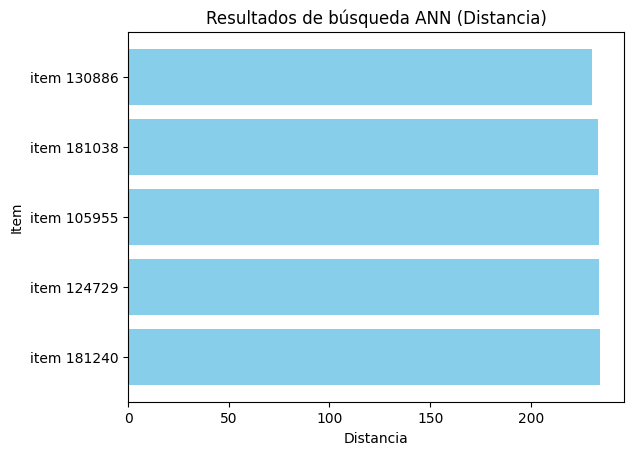

In [7]:

# Visualizar las distancias de los resultados obtenidos
plt.barh(resultados["item"], resultados["_distance"], color="skyblue")
plt.xlabel("Distancia")
plt.ylabel("Item")
plt.title("Resultados de búsqueda ANN (Distancia)")
plt.gca().invert_yaxis()  
plt.show()


In [3]:
# Crear índice en CPU (sin usar GPU)
start_time = time.time()
tbl.create_index(num_partitions=256, num_sub_vectors=96)
cpu_time = time.time() - start_time
print(f"Creación de índice en CPU tomó: {cpu_time:.4f} segundos")

# Crear índice en GPU (usando CUDA)
start_time = time.time()
tbl.create_index(num_partitions=256, num_sub_vectors=96, accelerator="cuda")
gpu_time = time.time() - start_time
print(f"Creación de índice en GPU tomó: {gpu_time:.4f} segundos")

# Comparar tiempos de creación de índices
print(f"Diferencia de tiempo (CPU vs GPU): {cpu_time - gpu_time:.4f} segundos")


Creación de índice en CPU tomó: 100.2390 segundos


/home/jake3120/itam/FuentesDeDatos/LanceDB/.venv/lib/python3.11/site-packages/lance/torch/data.py:44: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(nparr)
Assigning PQ codes: 100%|██████████| 199990/199990 [00:09<00:00, 21326.57it/s]


Creación de índice en GPU tomó: 136.2533 segundos
Diferencia de tiempo (CPU vs GPU): -36.0143 segundos
